# Complete Statistical Analysis

## Preliminaries

### Imports

In [1]:
import numpy as np
import math
import itertools
import os
import ruptures as rpt

import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro, kstest, jarque_bera
from statsmodels.multivariate.manova import MANOVA




# ....

#### Raw data directories

In [2]:
using_full = True
if using_full:
  physio_dir = 'CASE_full/data/interpolated/physiological'
  annotations_dir = 'CASE_full/data/interpolated/annotations'
  metadata_dir = 'CASE_full/metadata'
  total_num_participants = 30
else:
  physio_dir = 'CASE_snippet/data/interpolated/physiological'
  annotations_dir = 'CASE_snippet/data/interpolated/annotations'
  metadata_dir = 'CASE_snippet/metadata'
  total_num_participants = 2

# Participants to include
sub_nums = range(1, total_num_participants+1)

### Utility Functions

In [3]:
def load_csv_data(file_path):
    """
    Loads csv data
    """
    data = pd.read_csv(file_path)
    return data
    
def find_data_folder(folder_path, start_path='/content/drive'):
  '''
    :file_path: The complete path of the folder that includes the files.
    :start_path: The root folder on Drive from which we start the search
  '''
  #Search the root folder of the data and if found, continue searching the full path.
  start_data_folder = folder_path.split('/')[0]
  for root, dirs, files in os.walk(start_path):
      if start_data_folder in dirs:
          return os.path.join(root, folder_path)
  raise Exception(f"{start_data_folder} folder not found. Please check the directory structure.")


def plot_signal_segment(raw_signal, cleaned_signal, title, start_time, duration, sampling_rate=1000):
    """ Utility. Makes two graphs of a raw and a cleaned signal for demonstration """
    start_sample = int(start_time * sampling_rate)
    end_sample = int((start_time + duration) * sampling_rate)

    plt.figure(figsize=(14, 6))
    # Plot raw signal
    plt.subplot(2, 1, 1)
    plt.plot(raw_signal[start_sample:end_sample], label='Raw Signal')
    plt.title(f'Raw {title} Segment ({start_time}-{start_time + duration} sec)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    
    # Plot clean signal
    plt.subplot(2, 1, 2)
    plt.plot(cleaned_signal[start_sample:end_sample], label='Cleaned Signal')
    plt.title(f'Cleaned {title} Segment ({start_time}-{start_time + duration} sec)')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()

    plt.tight_layout()
    plt.show()


def extract_segments(cleaned_signal, start_time, end_time, original_timestamps):
    """ Utility. Extracts the signal segment given timestamps """
    start_index = original_timestamps[original_timestamps >= start_time].index[0]
    end_index = original_timestamps[original_timestamps <= end_time].index[-1]

    segment = cleaned_signal[start_index:end_index+1]
    return segment


def read_store_files(files_path, file_type='.csv'):
  '''
    :files_path: The complete Drive path that includes the files
    :file_type: The type of file we are searching for
  '''

  data_list = []
  files_names = []
  for file in os.listdir(files_path):
    if file.endswith(file_type):
      file_path = os.path.join(files_path, file)
      if file_type == '.csv':
        data = pd.read_csv(file_path)
      elif file_type == '.xlsx':
        data = pd.read_excel(file_path)

      data_list.append(data)
      files_names.append(file)

  return data_list, files_names


def retrieve_metadata(metadata_dir):
    # Retrieve metadata by reading the .xlsx files in the metadata_dir
    metadata, metadata_names = read_store_files(metadata_dir,'.xlsx')
    print(f'Metadata files: {metadata_names}')

    # Strip column names from whitespace 
    for i in range(len(metadata)):
        metadata[i].columns = metadata[i].columns.str.strip()

    # Store each metadata file separately (based on name)
    for i, file in enumerate(metadata_names):
        if file == 'videos.xlsx':
            videos_data = metadata[i].drop(metadata[i].columns[2:], axis=1).drop([0]).rename(columns={'Video-label': 'label', 'Video-ID': 'video_id'}).dropna()
            videos_data['video_id'] = videos_data['video_id'].astype(int)
        elif file == 'participants.xlsx':
            participant_data = metadata[i].rename(columns={'Participant-ID': 'participant_id', 'Age-Group': 'age_group', 'Video Sequence Used': 'sequence'})
        elif file == 'videos_duration_num.xlsx':
            duration_data = metadata[i].rename(columns={'video-ID': 'video_id', 'video-duration (in ms)': 'duration'})
        elif file == 'seqs_order_num.xlsx':
            sequence_order_data = metadata[i]
    
    return videos_data, participant_data, duration_data, sequence_order_data
# ....

### Dependent Variables (Features Extraction)

#### Preprocessing

#### Change Point Analysis

In [4]:
def keep_scary_videos(num_participants, data_dir, output_dir):
    ''' 
    Keeps scary videos with a reset index
    :num_participants: The number of participants
    :current_dir: The directory that contains the annotation data from all the participants
    '''
    
    for participant in range(num_participants):
        # Read the participant's file
        data = pd.read_csv(f'{data_dir}/sub_{participant+1}.csv')
        print(participant+1)

        # Keep only the segments of scary-1 and scary-2
        scary_1_segment = data[data['video'] == 7].reset_index(drop=True)
        scary_2_segment = data[data['video'] == 8].reset_index(drop=True)
        
        if 'annotation' in data_dir:
            # Rename the index column to 'timepoint' and make it start from 0, increasing by 50
            scary_1_segment.index = scary_1_segment.index * 50
            scary_1_segment.index.name = 'timepoint'
            
            scary_2_segment.index = scary_2_segment.index * 50
            scary_2_segment.index.name = 'timepoint'
        else:
            # Rename the index column to 'timepoint' 
            scary_1_segment.index.name = 'timepoint'
            scary_2_segment.index.name = 'timepoint'
        
        # Save the extracted segments in CSV files for later use
        scary_1_segment.to_csv(f'{output_dir}/sub_{participant+1}_scary_1.csv')
        scary_2_segment.to_csv(f'{output_dir}/sub_{participant+1}_scary_2.csv')


def combine_valence_arousal(valence, arousal, neutral_value=5):
    """ Adds the distance of valence and arousal from 5 (neutral_value) """
    combined_intensity = (valence - neutral_value).abs() + (arousal - neutral_value).abs()
    return combined_intensity


def detect_change_points(df, model="rbf", pen=20):
    algo = rpt.Pelt(model=model).fit(df.values)
    change_points = algo.predict(pen=pen)
    return change_points


def get_segments_excluding_first_last(change_points, series_length):
    """ Removes the first and last segment """
    if len(change_points) > 2:
        return change_points[1], change_points[-2]
    else:
        return 0, series_length



In [5]:
# Directory paths
annotation_videos_dir = 'annotation_videos'
annotations_after_cpa_dir = 'annotations_after_cpa'

physio_videos_dir = 'physio_videos'
physio_after_cpa_dir = 'physio_after_cpa'

# Make sure that the directories exist
os.makedirs(annotation_videos_dir, exist_ok=True)
os.makedirs(annotations_after_cpa_dir, exist_ok=True)

os.makedirs(physio_videos_dir, exist_ok=True)
os.makedirs(physio_after_cpa_dir, exist_ok=True)

# Keep the two scary videos from each annotation sequence and store them in the "annotation_videos_dir"
keep_scary_videos(total_num_participants, annotations_dir, annotation_videos_dir)

# Keep the two scary videos from each physiological sequence and store them in the "physio_videos_dir"
keep_scary_videos(total_num_participants, physio_dir, physio_videos_dir)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [6]:
# List of files in the annotation_videos and physio_videosdirectories
annotation_files = os.listdir(annotation_videos_dir)
physio_files = os.listdir(physio_videos_dir)

# Separate files for each video
files_scary_1 = [file for file in annotation_files if "scary_1" in file]
files_scary_2 = [file for file in annotation_files if "scary_2" in file]

def perform_cpa_on_annotations(files):
    """ Processes files and get average start and end points for each scary video """
    all_start_points = []
    all_end_points = []

    for i, file in enumerate(files):
        print(f"File: {file}")
        file_path = os.path.join(annotation_videos_dir, file)
        data = load_csv_data(file_path)
        
        # Keep the valence column and the arousal column separately and call the function that combines their intensity
        valence = data['valence']
        arousal = data['arousal']

        combined_intensity = combine_valence_arousal(valence, arousal)
        
        # Start with a standard pen value of 20
        pen = 15
        
        # Acceptable change points threshold
        change_points_threshold = 8
        
        while True:
            change_points = detect_change_points(combined_intensity.to_frame(), pen=pen)
            
            # Increase the pen value intil the segments are <= change_points_threshold
            if len(change_points) <= change_points_threshold:
                print(f'<={change_points_threshold}, --STOP--\n')
                break
            
            print(f'>{change_points_threshold}', end=', ')
            pen += 5
        
        # After the series is segmented using CPA, remove the first and the last segment
        start, end = get_segments_excluding_first_last(change_points, len(combined_intensity))
        
        # Keep a list of all the start and end points so later the mean can be computed
        all_start_points.append(start)
        all_end_points.append(end)

    # Keep the mean (average) of all start and end points as generar timestamps for our final segmentation
    if all_start_points and all_end_points:
        avg_start_point = int(np.mean(all_start_points))
        avg_end_point = int(np.mean(all_end_points))
    else:
        avg_start_point, avg_end_point = 0, len(combined_intensity)  # Default to entire series if no points

    return avg_start_point, avg_end_point


# Process files and get average start and end points for each video. One time for scary-1 and one time for scary-2
avg_start_scary_1, avg_end_scary_1 = perform_cpa_on_annotations(files_scary_1)
avg_start_scary_2, avg_end_scary_2 = perform_cpa_on_annotations(files_scary_2)

print(f"Average start and end points for scary_1: {avg_start_scary_1}, {avg_end_scary_1}")
print(f"Average start and end points for scary_2: {avg_start_scary_2}, {avg_end_scary_2}")



File: sub_16_scary_1.csv
<=8, --STOP--

File: sub_24_scary_1.csv
>8, <=8, --STOP--

File: sub_9_scary_1.csv
>8, >8, >8, >8, >8, >8, >8, >8, <=8, --STOP--

File: sub_28_scary_1.csv
>8, <=8, --STOP--

File: sub_13_scary_1.csv
>8, >8, >8, <=8, --STOP--

File: sub_21_scary_1.csv
>8, >8, >8, >8, >8, <=8, --STOP--

File: sub_5_scary_1.csv
<=8, --STOP--

File: sub_22_scary_1.csv
>8, >8, <=8, --STOP--

File: sub_6_scary_1.csv
>8, <=8, --STOP--

File: sub_10_scary_1.csv
>8, >8, >8, >8, >8, >8, >8, >8, <=8, --STOP--

File: sub_19_scary_1.csv
<=8, --STOP--

File: sub_3_scary_1.csv
>8, <=8, --STOP--

File: sub_27_scary_1.csv
>8, >8, >8, >8, <=8, --STOP--

File: sub_15_scary_1.csv
>8, >8, >8, <=8, --STOP--

File: sub_4_scary_1.csv
>8, >8, >8, >8, >8, >8, >8, >8, >8, >8, >8, >8, >8, >8, >8, >8, <=8, --STOP--

File: sub_20_scary_1.csv
>8, >8, <=8, --STOP--

File: sub_12_scary_1.csv
>8, >8, >8, >8, >8, >8, >8, <=8, --STOP--

File: sub_29_scary_1.csv
>8, >8, >8, >8, >8, >8, >8, >8, >8, >8, >8, >8, >8, 

In [7]:

# Apply the average start and end points to each participant's data and save the new CSVs in the "annotations_after_cpa_dir"
for i, file in enumerate(annotation_files):
    print(f"Annotation file: {i+1}")
    file_path = os.path.join(annotation_videos_dir, file)
    data = load_csv_data(file_path)
    
    if "scary_1" in file:
        start, end = avg_start_scary_1, avg_end_scary_1
    else:
        start, end = avg_start_scary_2, avg_end_scary_2
    
    most_significant_segment = data.iloc[start:end]
    
    output_file_path = os.path.join(annotations_after_cpa_dir, f"{os.path.splitext(file)[0]}_cpa.csv")
    most_significant_segment.to_csv(output_file_path, index=False)

    print(f"Processed {file} -> {output_file_path}")
    

# Apply the average start and end points to each participant's data and save the new CSVs in the "physio_after_cpa_dir"
for i, file in enumerate(physio_files):
    print(f"Physio file: {i+1}")
    file_path = os.path.join(physio_videos_dir, file)
    data = load_csv_data(file_path)
    
    if "scary_1" in file:
        start, end = avg_start_scary_1*50, avg_end_scary_1*50
    else:
        start, end = avg_start_scary_2*50, avg_end_scary_2*50
    
    most_significant_segment = data.iloc[start:end]
    
    output_file_path = os.path.join(physio_after_cpa_dir, f"{os.path.splitext(file)[0]}_cpa.csv")
    most_significant_segment.to_csv(output_file_path, index=False)

    print(f"Processed {file} -> {output_file_path}")
    

# Save average starting and ending times in a csv for later use
# These tme points are based on the segmented scary video and not the whole series
# For example if avg_start_scary_1 = 300, it means that the "important" part of the video data starts 300ms after the beginning of the video.
start_end_times = {
    'Annotation Start scary_1': avg_start_scary_1, 
    'Annotation End scary_1': avg_end_scary_1, 
    'Annotation Start scary_2': avg_start_scary_2, 
    'Annotation End scary_2': avg_end_scary_2,
    'Physio Start scary_1': avg_start_scary_1*50, 
    'Physio End scary_1': avg_end_scary_1*50, 
    'Physio Start scary_2': avg_start_scary_2*50, 
    'Physio End scary_2': avg_end_scary_2*50
}

start_end_times_df =  pd.DataFrame([start_end_times]).to_csv('CPA_Start_End_times.csv', index=False)

Annotation file: 1
Processed sub_16_scary_1.csv -> annotations_after_cpa/sub_16_scary_1_cpa.csv
Annotation file: 2
Processed sub_9_scary_2.csv -> annotations_after_cpa/sub_9_scary_2_cpa.csv
Annotation file: 3
Processed sub_24_scary_1.csv -> annotations_after_cpa/sub_24_scary_1_cpa.csv
Annotation file: 4
Processed sub_16_scary_2.csv -> annotations_after_cpa/sub_16_scary_2_cpa.csv
Annotation file: 5
Processed sub_9_scary_1.csv -> annotations_after_cpa/sub_9_scary_1_cpa.csv
Annotation file: 6
Processed sub_24_scary_2.csv -> annotations_after_cpa/sub_24_scary_2_cpa.csv
Annotation file: 7
Processed sub_13_scary_2.csv -> annotations_after_cpa/sub_13_scary_2_cpa.csv
Annotation file: 8
Processed sub_21_scary_2.csv -> annotations_after_cpa/sub_21_scary_2_cpa.csv
Annotation file: 9
Processed sub_28_scary_1.csv -> annotations_after_cpa/sub_28_scary_1_cpa.csv
Annotation file: 10
Processed sub_5_scary_2.csv -> annotations_after_cpa/sub_5_scary_2_cpa.csv
Annotation file: 11
Processed sub_13_scary_1.

##### Plot CPA limits

In [8]:
annotation_files

['sub_16_scary_1.csv',
 'sub_9_scary_2.csv',
 'sub_24_scary_1.csv',
 'sub_16_scary_2.csv',
 'sub_9_scary_1.csv',
 'sub_24_scary_2.csv',
 'sub_13_scary_2.csv',
 'sub_21_scary_2.csv',
 'sub_28_scary_1.csv',
 'sub_5_scary_2.csv',
 'sub_13_scary_1.csv',
 'sub_21_scary_1.csv',
 'sub_28_scary_2.csv',
 'sub_5_scary_1.csv',
 'sub_22_scary_1.csv',
 'sub_6_scary_1.csv',
 'sub_19_scary_2.csv',
 'sub_10_scary_1.csv',
 'sub_22_scary_2.csv',
 'sub_6_scary_2.csv',
 'sub_19_scary_1.csv',
 'sub_10_scary_2.csv',
 'sub_3_scary_2.csv',
 'sub_27_scary_2.csv',
 'sub_15_scary_2.csv',
 'sub_3_scary_1.csv',
 'sub_27_scary_1.csv',
 'sub_15_scary_1.csv',
 'sub_4_scary_1.csv',
 'sub_29_scary_2.csv',
 'sub_20_scary_1.csv',
 'sub_12_scary_1.csv',
 'sub_4_scary_2.csv',
 'sub_29_scary_1.csv',
 'sub_20_scary_2.csv',
 'sub_12_scary_2.csv',
 'sub_25_scary_2.csv',
 'sub_8_scary_1.csv',
 'sub_1_scary_2.csv',
 'sub_30_scary_1.csv',
 'sub_17_scary_2.csv',
 'sub_25_scary_1.csv',
 'sub_8_scary_2.csv',
 'sub_1_scary_1.csv',
 '

1. Annotation Scary-1: Valence
2. Annotation Scary-1: Arousal
3. Annotation Scary-2: Valence
4. Annotation Scary-2: Arousal

5. Physio Scary-1: ECG
6. Physio Scary-1: GSR
7. Physio Scary-2: ECG
8. Physio Scary-2: GSR


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

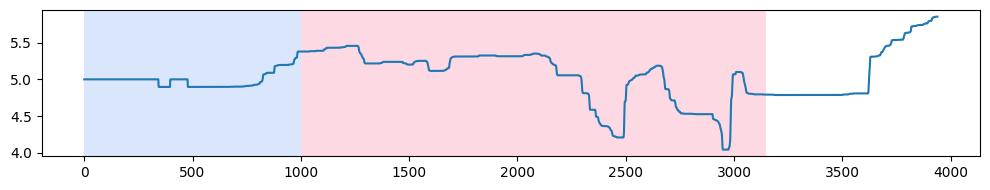

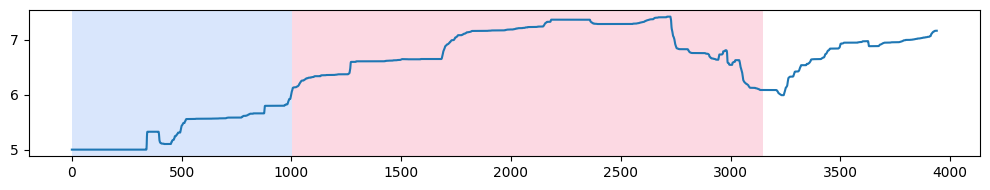

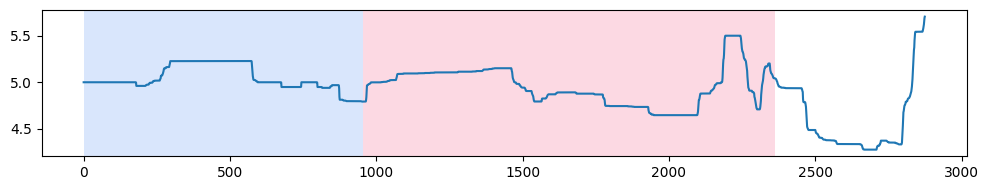

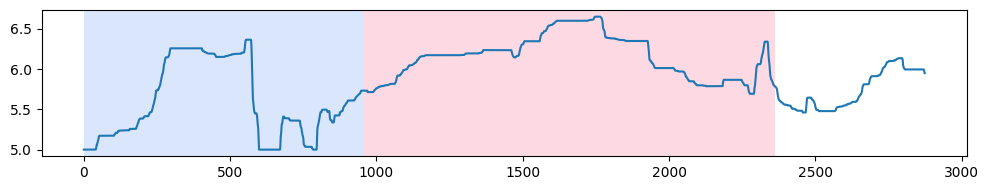

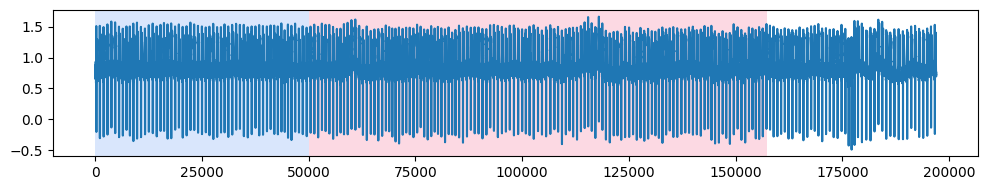

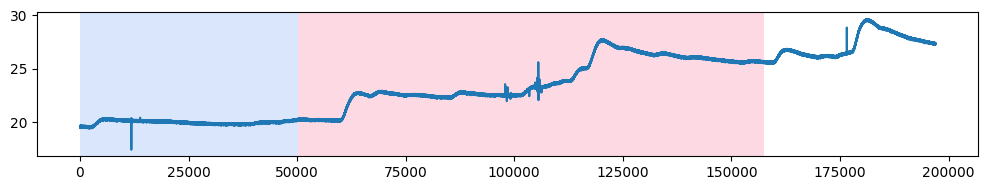

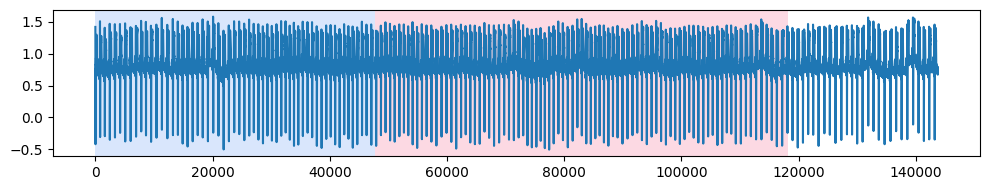

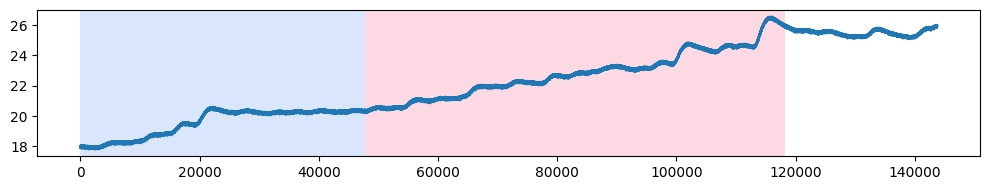

In [9]:
# NOTE: Change participant number to inpsect
participant_id = 11

# Example: Plot the annotation segments extracted from CPA
example_file_scary_1_annotation = pd.read_csv(f'{annotation_videos_dir}/sub_{participant_id}_scary_1.csv')
example_file_scary_2_annotation = pd.read_csv(f'{annotation_videos_dir}/sub_{participant_id}_scary_2.csv')

# Segments for video 1 and 2
segments = pd.read_csv('CPA_Start_End_times.csv')
segments_scary_1_annotation = [segments['Annotation Start scary_1'].values[0], segments['Annotation End scary_1'].values[0]]
segments_scary_2_annotation = [segments['Annotation Start scary_2'].values[0], segments['Annotation End scary_2'].values[0]]

print("1. Annotation Scary-1: Valence")
print("2. Annotation Scary-1: Arousal")
print("3. Annotation Scary-2: Valence")
print("4. Annotation Scary-2: Arousal")

rpt.display(example_file_scary_1_annotation['valence'], segments_scary_1_annotation)
rpt.display(example_file_scary_1_annotation['arousal'], segments_scary_1_annotation)
rpt.display(example_file_scary_2_annotation['valence'], segments_scary_2_annotation)
rpt.display(example_file_scary_2_annotation['arousal'], segments_scary_2_annotation)


# Example: Plot the physio segments extracted from CPA
example_file_scary_1_physio = pd.read_csv(f'{physio_videos_dir}/sub_{participant_id}_scary_1.csv')
example_file_scary_2_physio = pd.read_csv(f'{physio_videos_dir}/sub_{participant_id}_scary_2.csv')

# Segpents for video 1 and 2
segments = pd.read_csv('CPA_Start_End_times.csv')
segments_scary_1_physio = [segments['Physio Start scary_1'].values[0], segments['Physio End scary_1'].values[0]]
segments_scary_2_physio = [segments['Physio Start scary_2'].values[0], segments['Physio End scary_2'].values[0]]

print("\n5. Physio Scary-1: ECG")
print("6. Physio Scary-1: GSR")
print("7. Physio Scary-2: ECG")
print("8. Physio Scary-2: GSR")

rpt.display(example_file_scary_1_physio['ecg'], segments_scary_1_physio)
rpt.display(example_file_scary_1_physio['gsr'], segments_scary_1_physio)
rpt.display(example_file_scary_2_physio['ecg'], segments_scary_2_physio)
rpt.display(example_file_scary_2_physio['gsr'], segments_scary_2_physio)

##### Clean Signal and Extract Features from ECG and GSR data

In [10]:
def preprocess_signal(signal, data_type, visualization=False):
    """ Just cleans the signal (NOTE: ok for now).
    Set visualization to True to see a before-after example
    """
    if data_type == "ecg":
        cleaned_signal = nk.ecg_clean(signal, sampling_rate=1000)
    elif data_type == "gsr":
        cleaned_signal = nk.eda_clean(signal, sampling_rate=1000)
    else:
        raise ValueError("Unsupported data type")

    if visualization:
        # Plot a 5-second segment for demonstration
        plot_signal_segment(signal, cleaned_signal, 'Signal', start_time=400, duration=5 if data_type=='ecg' else 200)
    return cleaned_signal


In [11]:
def extract_features(segment, data_type, sampling_rate=1000):
    """ Extracts ECG and GSR features.

    ECG:
    - Heart Rate: Mean heart rate over the segment.
    - HRV SDNN: Standard deviation of NN intervals (HRV time-domain).
    - Mean RR Interval: Mean of RR intervals.
    - Poincaré SD1: Standard deviation of the points perpendicular to the line of identity in the Poincaré plot (HRV non-linear).
    - LF/HF Ratio: Ratio of low-frequency to high-frequency power (HRV frequency-domain).
    - RSA: Respiratory sinus arrhythmia, approximated by RMSSD.
    - PSD Total Power: Total power of the power spectral density.
    - PSD LF Power: Power in the low-frequency band of the PSD.
    - PSD HF Power: Power in the high-frequency band of the PSD.

    GSR:
    - SCL: Skin conductance level (mean tonic level).
    - SCR: Skin conductance response (mean phasic level).
    - Peak Amplitude: Maximum amplitude of the SCR peaks.
    - PSD Total Power: Total power of the power spectral density.
    - PSD LF Power: Power in the low-frequency band of the PSD.
    - PSD HF Power: Power in the high-frequency band of the PSD.

    Parameters:
    - segment: Array-like, the segment of the signal to analyze.
    - data_type: str, type of the signal ("ecg" or "gsr").
    - sampling_rate: int, sampling rate of the signal in Hz.

    Returns:
    - dict: A dictionary containing the extracted features.
    """
    if data_type == "ecg":
        signals, info = nk.ecg_process(segment, sampling_rate=sampling_rate)
        heart_rate = signals['ECG_Rate']

        peaks, info = nk.ecg_peaks(segment, sampling_rate=sampling_rate)
        hrv_time = nk.hrv_time(peaks, sampling_rate=sampling_rate).iloc[0].to_dict()
        hrv_nonlinear = nk.hrv_nonlinear(peaks, sampling_rate=sampling_rate).iloc[0].to_dict()
        hrv_frequency = nk.hrv_frequency(peaks, sampling_rate=sampling_rate).iloc[0].to_dict()

        psd = nk.signal_psd(segment, sampling_rate=sampling_rate)

        features = {
            "Heart Rate": heart_rate.mean(),
            "HRV SDNN": hrv_time['HRV_SDNN'],
            "Mean RR Interval": hrv_time['HRV_MeanNN'],
            "Poincaré SD1": hrv_nonlinear['HRV_SD1'],
            "LF/HF Ratio": hrv_frequency['HRV_LFHF'],
            "RSA": hrv_time['HRV_RMSSD'],
            "PSD Total Power": psd['Power'].sum(),
            "PSD LF Power": psd['Power'][psd['Frequency'] <= 0.15].sum(),
            "PSD HF Power": psd['Power'][(psd['Frequency'] > 0.15) & (psd['Frequency'] <= 0.4)].sum()
        }
    elif data_type == "gsr":
        signals, info = nk.eda_process(segment, sampling_rate=sampling_rate)
        scl = signals['EDA_Tonic'].mean()
        scr = signals['EDA_Phasic'].mean()

        peaks, info = nk.eda_peaks(segment, sampling_rate=sampling_rate)
        peak_amplitude = signals['EDA_Phasic'].max()
        # this is not useful now, cause it's always one
        # peak_frequency = len(peaks['SCR_Peaks']) / len(segment)

        psd = nk.signal_psd(segment, sampling_rate=sampling_rate)

        features = {
            "SCL": scl,
            "SCR": scr,
            "Peak Amplitude": peak_amplitude,
            "PSD Total Power": psd['Power'].sum(),
            "PSD LF Power": psd['Power'][psd['Frequency'] <= 0.15].sum(),
            "PSD HF Power": psd['Power'][(psd['Frequency'] > 0.15) & (psd['Frequency'] <= 0.4)].sum()
        }
    else:
        raise ValueError("Unsupported data type")
    return features


# TODO: Fix this with new segmentation approach
def get_segment_timestamps(data, segmentation=False):
    """ Gets the df data based on the timestamps
    (NOTE: this allows for further segmentation by being flexible and
    not relying on adding new df columns or indices)
    """
    
    # Get data only for videos 7 and 8 (scary videos)
    scary_1_data = data[data['video'] == 7]
    scary_2_data = data[data['video'] == 8]

    # Get the start and end timestamps
    scary_1_start = scary_1_data['daqtime'].iloc[0]
    scary_1_end = scary_1_data['daqtime'].iloc[-1]
    scary_2_start = scary_2_data['daqtime'].iloc[0]
    scary_2_end = scary_2_data['daqtime'].iloc[-1]

    print(f"scary_1_start: {scary_1_start}")
    print(f"scary_1_end: {scary_1_end}")
    print(f"scary_2_start: {scary_2_start}")
    print(f"scary_2_end: {scary_2_end}")
    print()

    # Swap the videos if needed (based on presented order)
    if scary_1_start > scary_2_start: # compare start timestamps
        (scary_1_start, scary_1_end), (scary_2_start, scary_2_end) = (scary_2_start, scary_2_end), (scary_1_start, scary_1_end)
        print("swapped")
   

    return (scary_1_start, scary_1_end), (scary_2_start, scary_2_end)


# # TODO: Fix this with new segmentation approach
# def swap_videos(scary_videos):
#     """ Gets the df data based on the timestamps
#     (NOTE: this allows for further segmentation by being flexible and
#     not relying on adding new df columns or indices)
#     """
    
#     # # Get data only for videos 7 and 8 (scary videos)
#     # scary_1_data = data[data['video'] == 7]
#     # scary_2_data = data[data['video'] == 8]

#     scary_1_data, scary_2_data = scary_videos

#     # Get the start and end timestamps
#     scary_1_start = scary_1_data['daqtime'].iloc[0]
   
#     scary_1_end = scary_1_data['daqtime'].iloc[-1]
#     scary_2_start = scary_2_data['daqtime'].iloc[0]
#     scary_2_end = scary_2_data['daqtime'].iloc[-1]
    
#     print(f"scary_1_start: {scary_1_start}")
#     print(f"scary_1_end: {scary_1_end}")
#     print(f"scary_2_start: {scary_2_start}")
#     print(f"scary_2_end: {scary_2_end}")
#     print()

#     # Swap the videos if needed (based on presented order)
#     if scary_1_start > scary_2_start: # compare start timestamps
#         (scary_1_start, scary_1_end), (scary_2_start, scary_2_end) = (scary_2_start, scary_2_end), (scary_1_start, scary_1_end)
#         print("swapped")
   

#     return (scary_1_start, scary_1_end), (scary_2_start, scary_2_end)

In [12]:

CPA = False
physio_dir = physio_after_cpa_dir if CPA else physio_videos_dir

# Initialize list (NOTE: we will convert to dataframe later)
results = []


sub_nums = range(1, 31)

# TODO: combine csvs. (CPA)

for sub_num in sub_nums:
   
 
    #data_path = os.path.join(physio_dir, f'sub_{sub_num}.csv')

    print(f"\n----------- Participant {sub_num} data -----------")
    
   
    scary_1_filename = f'sub_{sub_num}_scary_1'
    scary_2_filename = f'sub_{sub_num}_scary_2'
    
    if CPA:
        scary_1_filename += "_cpa"
        scary_2_filename += "_cpa"
        
    scary_1_filename += ".csv"
    scary_2_filename += ".csv"

    
    scary_1 = load_csv_data(os.path.join(physio_dir, scary_1_filename))
    scary_2 = load_csv_data(os.path.join(physio_dir, scary_2_filename))
   
    data = pd.concat([scary_1, scary_2], ignore_index=True)
    print(data.head())
    

    # filename = f'sub_{sub_num}_scary_{scary_num+1}'
    # if CPA:
    #     filename += "_cpa"
        
    # filename += ".csv"
    # data_path = os.path.join(physio_dir, filename)
    # data = load_csv_data(data_path)

    ecg_signal = data['ecg']
    gsr_signal = data['gsr']
    original_timestamps = data['daqtime']
   
   

    # Clean signals (set to True to visualize before-after)
    ecg_cleaned = preprocess_signal(ecg_signal, data_type="ecg", visualization=False)
    gsr_cleaned = preprocess_signal(gsr_signal, data_type="gsr", visualization=False)

    # Get timestamps for scary videos SWAP
    (scary_1_start, scary_1_end), (scary_2_start, scary_2_end) = get_segment_timestamps(data)
    
    
    
    
        
    # Extract segment data (NOTE: something like this could be used later even if we segment the videos further)
    ecg_scary_1_segment = extract_segments(ecg_cleaned, scary_1_start, scary_1_end, original_timestamps)
    ecg_scary_2_segment = extract_segments(ecg_cleaned, scary_2_start, scary_2_end, original_timestamps)

    gsr_scary_1_segment = extract_segments(gsr_cleaned, scary_1_start, scary_1_end, original_timestamps)
    gsr_scary_2_segment = extract_segments(gsr_cleaned, scary_2_start, scary_2_end, original_timestamps)

    # Calculate ECG and GSR features for both videos
    ecg_features_scary_1 = extract_features(ecg_scary_1_segment, data_type="ecg")
    ecg_features_scary_2 = extract_features(ecg_scary_2_segment, data_type="ecg")

    gsr_features_scary_1 = extract_features(gsr_scary_1_segment, data_type="gsr")
    gsr_features_scary_2 = extract_features(gsr_scary_2_segment, data_type="gsr")

    # Calculate differences for all features (to use in statistical analysis)
    ecg_features_diff = {f'diff_ecg_{key}': ecg_features_scary_2[key] - ecg_features_scary_1[key] for key in ecg_features_scary_1.keys()}
    gsr_features_diff = {f'diff_gsr_{key}': gsr_features_scary_2[key] - gsr_features_scary_1[key] for key in gsr_features_scary_1.keys()}

    # Compile all features into a single dictionary
    participant_features = {'participant': sub_num}
    participant_features.update({f'scary_1_ecg_{key}': value for key, value in ecg_features_scary_1.items()})
    participant_features.update({f'scary_2_ecg_{key}': value for key, value in ecg_features_scary_2.items()})
    participant_features.update(ecg_features_diff)
    participant_features.update({f'scary_1_gsr_{key}': value for key, value in gsr_features_scary_1.items()})
    participant_features.update({f'scary_2_gsr_{key}': value for key, value in gsr_features_scary_2.items()})
    participant_features.update(gsr_features_diff)

    # Add to results
    results.append(participant_features)


----------- Participant 1 data -----------
   timepoint  daqtime    ecg     bvp    gsr     rsp     skt  emg_zygo  \
0          0  1030876  0.817  35.621  4.389  26.991  28.867     7.905   
1          1  1030877  0.807  35.759  4.361  27.010  28.864     7.863   
2          2  1030878  0.807  35.876  4.388  27.029  28.870     7.863   
3          3  1030879  0.803  36.184  4.381  27.020  28.874     7.782   
4          4  1030880  0.794  35.985  4.381  26.991  28.860     7.700   

   emg_coru  emg_trap  video  
0     6.549     4.948      7  
1     6.590     5.029      7  
2     6.671     5.070      7  
3     6.672     5.111      7  
4     6.631     5.030      7  
scary_1_start: 1030876
scary_1_end: 1227875
scary_2_start: 2187834
scary_2_end: 2331583


----------- Participant 2 data -----------
   timepoint  daqtime    ecg     bvp    gsr     rsp     skt  emg_zygo  \
0          0  2134584  1.148  37.920  9.178  27.242  28.758     6.097   
1          1  2134585  1.142  37.911  9.151  27.194 

IndexError: single positional indexer is out-of-bounds

##### Save to csv

In [ ]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save
output_filepath = 'preprocessed_data/dv_data.csv'
results_df.to_csv(output_filepath, index=False)

print(f"Results saved to {output_filepath}.")

### Independent Variables (Predictors)

In [ ]:
# TODO Function compute start end points


In [ ]:
def compute_independent_variables(sequence_order_data, participant_data, 
                                    videos_data, num_participants, results_name='preprocessed_data/iv_data.csv'):
    
    '''
    :sequence_order_data: Dataframe where each column is a participant and the rows are the sequence of videos whatched
    :participant_data: Dataframe that includes information about each participant. We use it to extract the sequence ID
    :videos_data: Includes the label, ID and duration of each video
    :num_participants: The number of participants
    :results_name: Name of the result CSV file that will contain the Independent Variables for each participant.
    '''

    # Extract video IDs based on labels
    def extract_video_ids(label_list, videos_data):
        return videos_data[videos_data['label'].isin(label_list)].drop(columns=('label'))['video_id'].tolist()
    
    SCARY_LABELS=['scary-1', 'scary-2']
    LOW_AROUSAL_LABELS=['relaxed-1', 'relaxed-2', 'boring-1', 'boring-2']

    scary_videos_ids = extract_video_ids(SCARY_LABELS, videos_data) # IDs of the scary videos
    low_arousal_videos_ids = extract_video_ids(LOW_AROUSAL_LABELS, videos_data) # IDs of the low arousal videos
    print(f'Scary videos IDs: {scary_videos_ids}\nLow Arousal videos IDs: {low_arousal_videos_ids}')
    
    # Read the scary videos starting and ending points from the csv file
    start_end_points_df = pd.read_csv('start_end_points.csv')
    
    # Initialize data arrays
    def initialize_arrays(shape, fill_value=0):
        return np.zeros(shape) + fill_value
    
    interlude_durations = initialize_arrays(num_participants) # Interlude time between scary videos for each participant
    count_interlude_videos_total = initialize_arrays(num_participants)  # Initialize count of interlude videos total
    count_interlude_low_arousal = initialize_arrays(num_participants) # Initialize count of interlude low arousal
    logratio_low_div_total = initialize_arrays(num_participants)  # Initialize log ratio (low arousal / total interlude)
    
    # Extract the sequence ID of each participant. It is the same as the participant number but we extract it this way in case the .xlsx change.
    sequence_id_of_participants = np.array([participant_data.iloc[participant]['sequence'] for participant in range(num_participants)])

    # Helper function to compute log ratio
    def compute_log_ratio(count_low, count_total):
        return np.around(np.log((count_low + 1) / (count_total + 1)), decimals=4)
    
    # Process each participant
    for participant in range(num_participants):
        print('\n', '-' * 15, f'Participant {participant + 1}', '-' * 15)
        
        # Using the sequence id, get the video sequence of the specific participant 
        participant_sequence = pd.DataFrame(sequence_order_data[f'sub_{sequence_id_of_participants[participant]}']).rename(columns={f'sub_{participant+1}': 'sequence'})
        print(f'- Sequence ID: {sequence_id_of_participants[participant]}')
        print(f'- Sequence: {participant_sequence["sequence"].tolist()}')
        
        # Retrieve scary video start and end 
        scary_1_start, scary_1_end, scary_2_start, scary_2_end = \
        start_end_points_df['scary_1_start'].iloc[participant], start_end_points_df['scary_1_end'].iloc[participant], \
        start_end_points_df['scary_2_start'].iloc[participant], start_end_points_df['scary_2_end'].iloc[participant]
        print(f'- Timepoints: Scary 1 start: {scary_1_start} || Scary 1 end: {scary_1_end} || Scary 2 start: {scary_2_start} || Scary 2 end: {scary_2_end}')

        # Find locations of the two scary videos in the sequence
        scary_indices = participant_sequence[participant_sequence['sequence'].isin(scary_videos_ids)].index.values.tolist()
        first_scary_loc, second_scary_loc = scary_indices[0], scary_indices[1]
        print(f'- Locs in sequence: Scary 1: {first_scary_loc} || Scary 2: {second_scary_loc}')
        
        # Retrieve all the Interlude videos based on the sequence and the 1st & 2nd scary locations. (if any)
        interlude_videos = participant_sequence.iloc[first_scary_loc + 1 : second_scary_loc][f'sequence'].values.tolist() if second_scary_loc > first_scary_loc + 1 else []
        count_interlude_videos_total[participant] = np.floor(len(interlude_videos) / 2) # Divide by 2 so we don't count the bluVid between each video
        print(f'- Number of interlude videos (no bluVid): {int(count_interlude_videos_total[participant])}')
        
        # Compute Low Arousal Interlude videos
        count_interlude_low_arousal[participant] = len([vid for vid in interlude_videos if vid in low_arousal_videos_ids])
        print(f'- Low Arousal Interlude videos: {int(count_interlude_low_arousal[participant])}')
        
        # Compute the Log Ratio between the total Interlude videos and the Low Arousal Interlude videos  
        logratio_low_div_total[participant] = compute_log_ratio(count_interlude_low_arousal[participant], count_interlude_videos_total[participant])
        print(f'- Log Ratio: {logratio_low_div_total[participant]}')
        
        # Compute Interlude Durations
        interlude_durations[participant] = scary_2_start - scary_1_end
        print(f'- Interlude duration (with bluVid): {interlude_durations[participant]}')
        
    # Save the extracted features in dictionary and save it as dataframe CSV
    data = {
        'Participant': range(1, num_participants + 1),
        'Interlude Duration': interlude_durations[:],
        'Interlude Video Count': count_interlude_videos_total[:],
        'Interlude Low Arousal': count_interlude_low_arousal[:],
        'LogRatio': logratio_low_div_total[:],
    }
    results_df = pd.DataFrame(data)

    results_df.to_csv(results_name, index=False)

In [ ]:
# Retrieve the metadata
videos_data, participant_data, duration_data, sequence_order_data = retrieve_metadata(metadata_dir)

In [19]:
# Call the Independent Variable process that extracts the IVs from each participant
compute_independent_variables(sequence_order_data, participant_data, videos_data, total_num_participants)


Scary videos IDs: [7, 8]
Amusing videos IDs: [1, 2]
Low Arousal videos IDs: [3, 4, 5, 6]

 --------------- Participant 1 ---------------
- Sequence ID: 1
- Sequence: [10, 11, 3, 11, 1, 11, 5, 11, 7, 11, 4, 11, 2, 11, 6, 11, 8, 12]
- Timepoints: Scary 1 start: 1030876 || Scary 1 end: 1227875 || Scary 2 start: 2187834 || Scary 2 end: 2331583
- Locs in sequence: Scary 1: 8 || Scary 2: 16
- Number of interlude videos (no bluVid): 3
- Low Arousal Interlude videos: 2
- Log Ratio: -0.2877
- Interlude duration (with bluVid): 959959.0

 --------------- Participant 2 ---------------
- Sequence ID: 2
- Sequence: [10, 11, 2, 11, 6, 11, 4, 11, 8, 11, 1, 11, 3, 11, 5, 11, 7, 12]
- Timepoints: Scary 1 start: 1061459 || Scary 1 end: 1205208 || Scary 2 start: 2134584 || Scary 2 end: 2331583
- Locs in sequence: Scary 1: 8 || Scary 2: 16
- Number of interlude videos (no bluVid): 3
- Low Arousal Interlude videos: 2
- Log Ratio: -0.2877
- Interlude duration (with bluVid): 929376.0

 --------------- Partici

## Statistical Analysis

### Data preparation

In [ ]:
# Merge the IV and the DV CSV files 
iv_df = pd.read_csv('iv_data.csv')
dv_df = pd.read_csv('dv_data.csv')

combined_df = pd.concat([dv_df.iloc[:, :1], iv_df.iloc[:, 1:], dv_df.iloc[:, 1:]], axis=1) # Keep the column "Participant" of the dv dataframe and add the iv columns after it.


In [ ]:
# rounding/transforming

In [ ]:
# Save the combined DataFrame
output_path = 'preprocessed_data/iv_dv_data.csv'  # Replace with your desired output path
combined_df.to_csv(output_path, index=False)

print(f'iv_dv_clean CSV saved to {output_path}')

### Correlation

In [197]:
data_path = "iv_dv_data.csv"
data = load_csv_data(data_path)
data.head()

,participant,Interlude Duration,Interlude Video Count,Interlude Low Arousal,LogRatio,scary_1_ecg_Heart Rate,scary_1_ecg_HRV SDNN,scary_1_ecg_Mean RR Interval,scary_1_ecg_Poincaré SD1,scary_1_ecg_LF/HF Ratio,...,scary_2_gsr_Peak Amplitude,scary_2_gsr_PSD Total Power,scary_2_gsr_PSD LF Power,scary_2_gsr_PSD HF Power,diff_gsr_SCL,diff_gsr_SCR,diff_gsr_Peak Amplitude,diff_gsr_PSD Total Power,diff_gsr_PSD LF Power,diff_gsr_PSD HF Power
0,1,959959.0,3.0,2.0,-0.2877,84.237003,108.089897,712.756364,28.685912,3.011014,...,0.066509,0.032542,0.032072,0.000337,-4.907596,0.000063,-0.444185,0.016376,0.016010,0.000237
1,2,929376.0,3.0,2.0,-0.2877,66.030824,51.130114,909.159236,35.274958,0.717753,...,1.113085,0.233986,0.231020,0.002880,3.355576,0.001696,-0.571826,0.147734,0.153973,-0.006105
2,3,1237459.0,4.0,2.0,-0.5108,73.680695,89.976035,811.371901,45.071634,1.020986,...,0.773130,0.081055,0.080161,0.000870,2.255484,-0.004137,0.114779,0.032012,0.031664,0.000335
3,4,890543.0,3.0,3.0,0.0000,55.450141,112.026191,1074.719697,76.830568,0.447687,...,2.666756,0.193488,0.191615,0.001862,9.230335,0.003017,0.763255,0.134367,0.133171,0.001194
4,5,623793.0,2.0,2.0,0.0000,68.818342,95.952448,872.084444,34.543499,2.835397,...,3.013577,0.406217,0.277943,0.113461,1.360499,-0.004445,-1.698186,-0.227748,-0.319633,0.079484


In [166]:
relevant_columns = ['Interlude Duration', 'Log Ratio', 'diff_ecg_Mean RR Interval', 'diff_ecg_Heart Rate', 'diff_ecg_HRV SDNN', 'diff_gsr_Peak Amplitude', 'diff_gsr_SCR', 'diff_gsr_SCL']
data = data[relevant_columns]
data.head()

,Interlude Duration,Log Ratio,diff_ecg_Mean RR Interval,diff_ecg_Heart Rate,diff_ecg_HRV SDNN,diff_gsr_Peak Amplitude,diff_gsr_SCR,diff_gsr_SCL
0,959.958333,-0.2877,46.897892,-5.239475,-63.649916,-0.444185,0.000063,-4.907596
1,929.375000,-0.2877,7.116465,-0.513969,20.286824,-0.571826,0.001696,3.355576
2,1237.458333,-0.5108,-91.967860,9.686036,5.121288,0.114779,-0.004137,2.255484
3,890.541667,0.0000,-8.577620,0.865101,-25.110028,0.763255,0.003017,9.230335
4,623.791667,0.0000,-57.398730,4.835005,-19.139729,-1.698186,-0.004445,1.360499


In [167]:
# Calculate the Pearson correlation matrix
correlation_matrix = data.corr(method='pearson')
correlation_matrix

,Interlude Duration,Log Ratio,diff_ecg_Mean RR Interval,diff_ecg_Heart Rate,diff_ecg_HRV SDNN,diff_gsr_Peak Amplitude,diff_gsr_SCR,diff_gsr_SCL
Interlude Duration,1.000000,-0.331678,0.096730,-0.065541,-0.025039,0.425979,0.233522,-0.071301
Log Ratio,-0.331678,1.000000,-0.055395,-0.043790,0.077094,-0.185790,-0.389022,0.113073
diff_ecg_Mean RR Interval,0.096730,-0.055395,1.000000,-0.971237,-0.423386,-0.080691,0.149668,-0.553317
diff_ecg_Heart Rate,-0.065541,-0.043790,-0.971237,1.000000,0.353399,0.097516,-0.139974,0.518482
diff_ecg_HRV SDNN,-0.025039,0.077094,-0.423386,0.353399,1.000000,0.239692,0.038119,0.468282
diff_gsr_Peak Amplitude,0.425979,-0.185790,-0.080691,0.097516,0.239692,1.000000,0.384886,0.563651
diff_gsr_SCR,0.233522,-0.389022,0.149668,-0.139974,0.038119,0.384886,1.000000,0.187699
diff_gsr_SCL,-0.071301,0.113073,-0.553317,0.518482,0.468282,0.563651,0.187699,1.000000


### Regression Analyses

### NOTE: ASK LUKAS 
### 1)problem if the interaction term is 0?
### 2)when checking assumptions with or without interaction

### Linear Multiple Regression

##### Assumptions Checking

###### Set up

In [169]:
# Define predictors and response variables
X = data[['Interlude Duration', 'Log Ratio']]
y_vars = ['diff_ecg_Mean RR Interval', 'diff_ecg_Heart Rate', 'diff_gsr_Peak Amplitude', 'diff_gsr_SCL']

# Define model with interaction term
X_w_interaction = X.copy()
X_w_interaction['Interaction'] = X_w_interaction['Interlude Duration'] * X_w_interaction['Log Ratio']

# Add constant to the predictors
X = sm.add_constant(X)
X_w_interaction = sm.add_constant(X_w_interaction)

# Fit models and store in dictionary
models = {}

for i, response_var in enumerate(y_vars, 1):
    model_key = f'model{i}'
    models[model_key] = {
        'model_no_interaction': sm.OLS(data[response_var], X).fit(),
        'model_w_interaction': sm.OLS(data[response_var], X_w_interaction).fit(),
        'response_var': response_var
    }


def derive_formula(model):
    """ Derive linear formulat from model """
    predictors = model.model.exog_names
    response = model.model.endog_names
    formula = f"{response} ~ " + " + ".join(predictors)
    return formula

###### Choose model

In [181]:
model_name = "model2" # put model here... ('model1', 'model2', 'model3', 'model4')

In [182]:
model_info = models[model_name]
model = model_info['model_no_interaction']
# print(model.summary())
response_var = model_info['response_var']
print(f"Selected model: {model_key}\n-Predictors: {', '.join(X.columns.tolist())}\n-Response Variable: {response_var}")

Selected model: model4
-Predictors: const, Interlude Duration, Log Ratio
-Response Variable: diff_ecg_Heart Rate


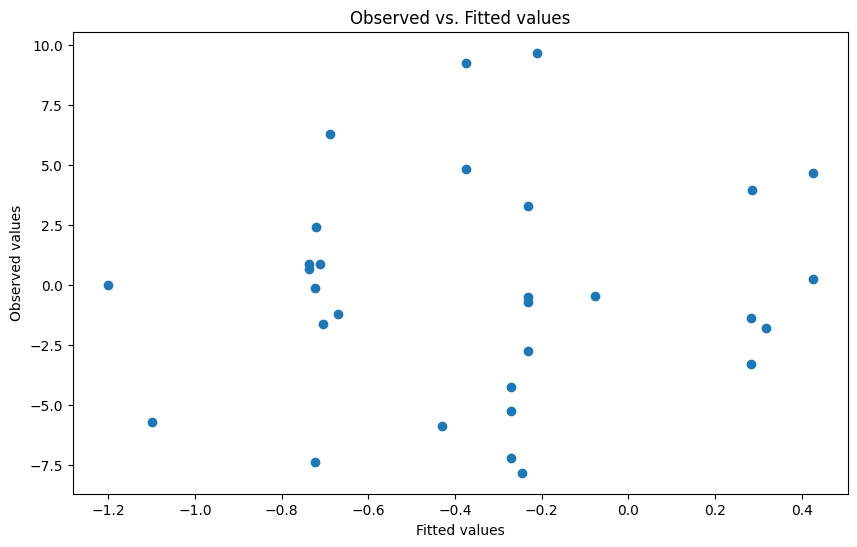

In [183]:
# 1. Linearity: Plot observed vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, y[response_var])
plt.xlabel('Fitted values')
plt.ylabel('Observed values')
plt.title('Observed vs. Fitted values')
plt.show()

In [184]:
# 2. Independence: Durbin-Watson test
dw_test = sm.stats.durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_test}')

Durbin-Watson statistic: 2.0586880378150076


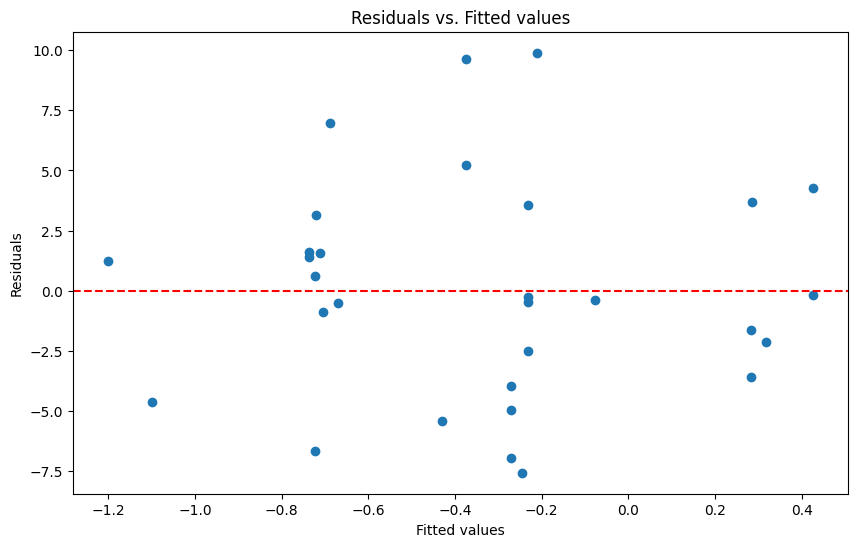

{'LM Statistic': 0.1504653406045564, 'LM-Test p-value': 0.9275276530811194, 'F-Statistic': 0.06805071239266819, 'F-Test p-value': 0.9343728047772765}


In [185]:
# 3. Homoscedasticity: Plot residuals vs. fitted values
plt.figure(figsize=(10, 6))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted values')
plt.show()

# Breusch-Pagan test for homoscedasticity
bp_test = het_breuschpagan(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

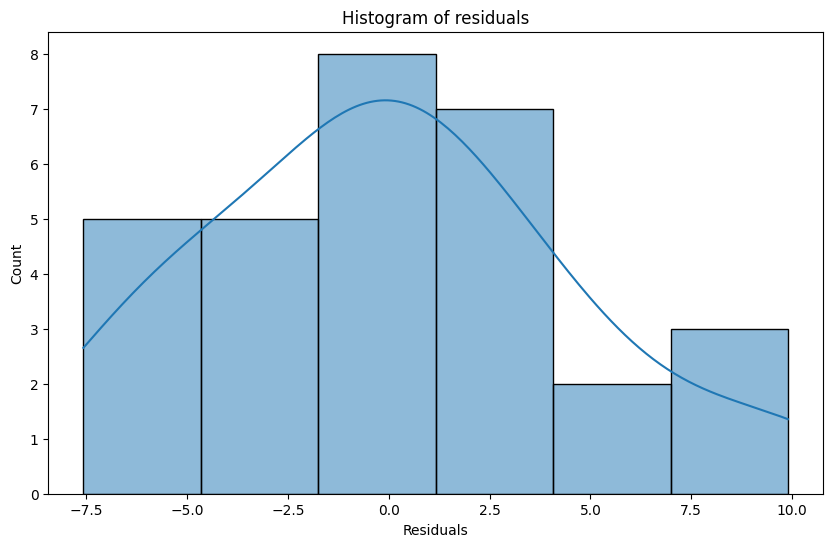

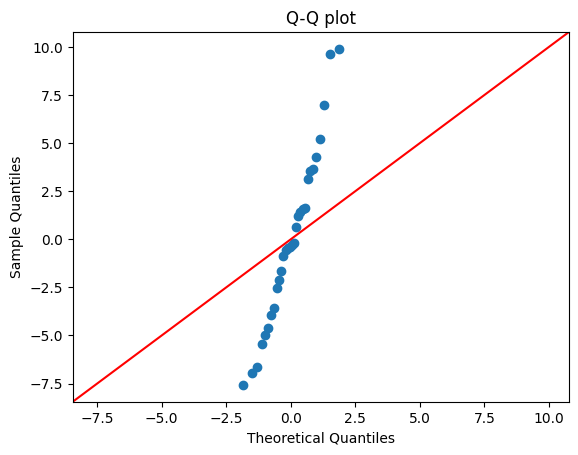

Shapiro-Wilk test: ShapiroResult(statistic=0.9714261293411255, pvalue=0.5788938403129578)
Kolmogorov-Smirnov test: KstestResult(statistic=0.3165263971037769, pvalue=0.003590637361464588, statistic_location=-2.124673424477797, statistic_sign=1)
Jarque-Bera test: SignificanceResult(statistic=0.7871797564102928, pvalue=0.6746306802572481)


In [186]:
# 4. Normality: Histogram and Q-Q plot of residuals
plt.figure(figsize=(10, 6))
sns.histplot(model.resid, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of residuals')
plt.show()

# Q-Q plot
sm.qqplot(model.resid, line='45')
plt.title('Q-Q plot')
plt.show()

# Shapiro-Wilk test
shapiro_test = shapiro(model.resid)
print(f'Shapiro-Wilk test: {shapiro_test}')

# Kolmogorov-Smirnov test
ks_test = kstest(model.resid, 'norm')
print(f'Kolmogorov-Smirnov test: {ks_test}')

# Jarque-Bera test
jb_test = jarque_bera(model.resid)
print(f'Jarque-Bera test: {jb_test}')

In [187]:
# 5. Multicollinearity: Variance Inflation Factor (VIF)
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


             Variable        VIF
0               const  11.654882
1  Interlude Duration   1.123608
2           Log Ratio   1.123608


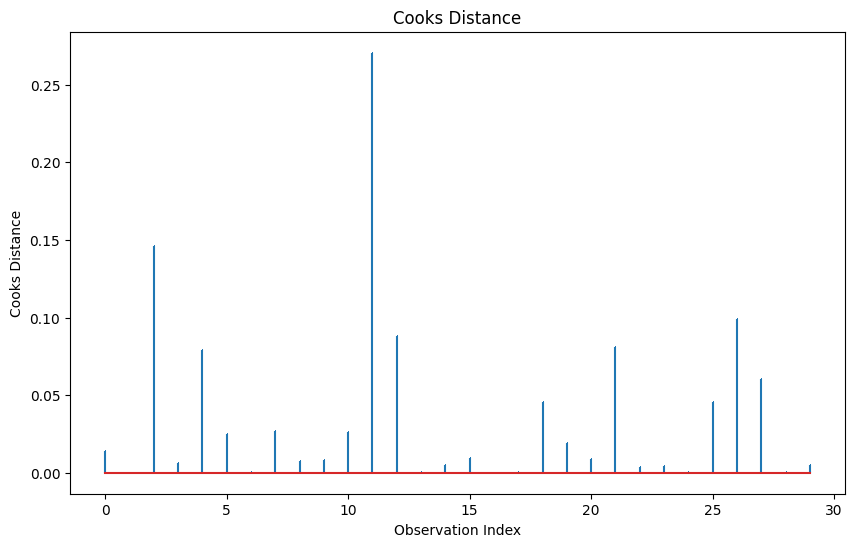

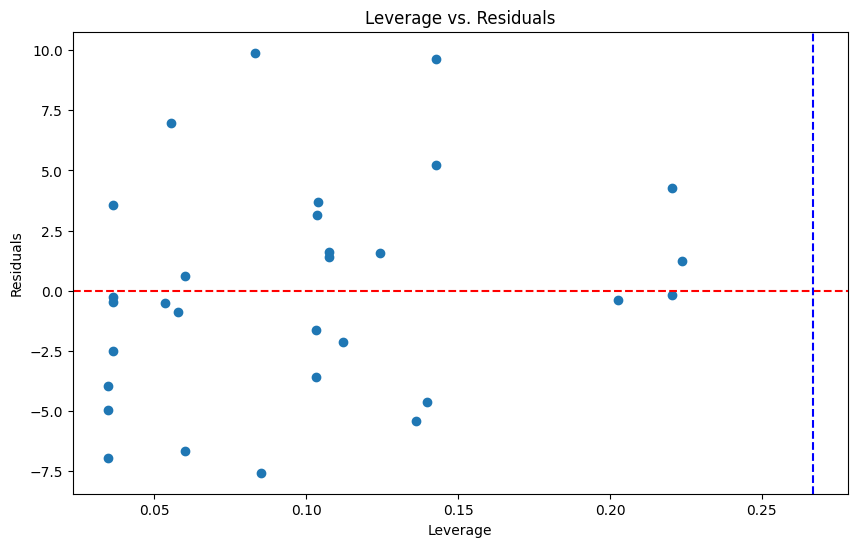

In [188]:
# Additional Assumptions:

# Influential Points: Cook's Distance
influence = OLSInfluence(model)
cooks_d = influence.cooks_distance[0]

plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.title('Cooks Distance')
plt.xlabel('Observation Index')
plt.ylabel('Cooks Distance')
plt.show()

# Leverage plot
plt.figure(figsize=(10, 6))
plt.scatter(influence.hat_matrix_diag, model.resid)
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.title('Leverage vs. Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.axvline(2 * (X.shape[1] + 1) / len(X), color='blue', linestyle='--')
plt.show()

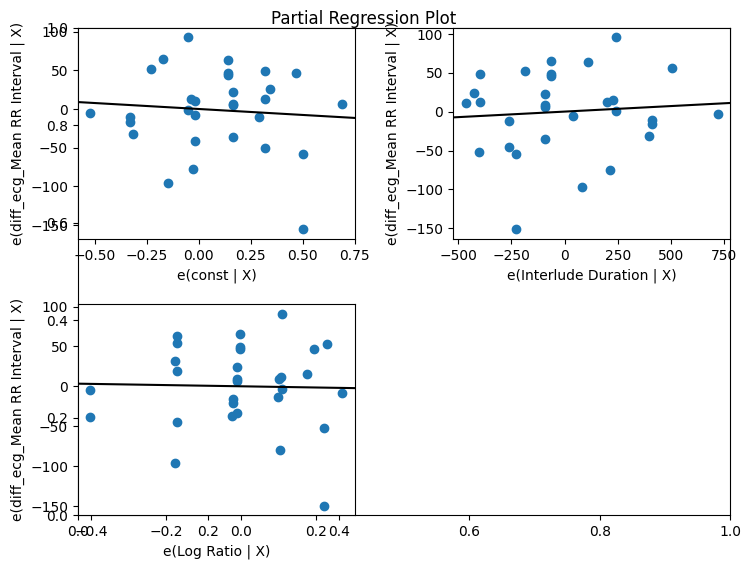

In [180]:
# 7. Linearity of Relationships: Partial Regression Plots
fig, ax = plt.subplots(figsize=(8, 6))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)
plt.show()

##### Fit models

###### change model here (optional)

In [221]:
model_name = "model4" # put model here... ('model1', 'model2', 'model3', 'model4')
# ------
model_info = models[model_name]
model = model_info['model_no_interaction']
# print(model.summary())
response_var = model_info['response_var']
print(f"Selected model: {model_name}\n-Predictors: {', '.join(X.columns.tolist())}\n-Response Variable: {response_var}")

Selected model: model4
-Predictors: const, Interlude Duration, Log Ratio
-Response Variable: diff_gsr_SCL


###### View model summaries

In [222]:
# Print selected model results with and without the interaction term
formula_no_interaction = derive_formula(models[model_name]['model_no_interaction'])
formula_w_interaction = derive_formula(models[model_name]['model_w_interaction'])

print(f"Summary for {formula_no_interaction}:")
print(models[model_name]['model_no_interaction'].summary())

Summary for diff_gsr_SCL ~ const + Interlude Duration + Log Ratio:
                            OLS Regression Results                            
Dep. Variable:           diff_gsr_SCL   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.059
Method:                 Least Squares   F-statistic:                    0.1926
Date:                Sun, 26 May 2024   Prob (F-statistic):              0.826
Time:                        23:24:16   Log-Likelihood:                -105.17
No. Observations:                  30   AIC:                             216.3
Df Residuals:                      27   BIC:                             220.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

In [223]:
print(f"\nSummary for {formula_w_interaction}:")
print(models[model_name]['model_w_interaction'].summary())


Summary for diff_gsr_SCL ~ const + Interlude Duration + Log Ratio + Interaction:
                            OLS Regression Results                            
Dep. Variable:           diff_gsr_SCL   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.181
Date:                Sun, 26 May 2024   Prob (F-statistic):              0.336
Time:                        23:24:17   Log-Likelihood:                -103.47
No. Observations:                  30   AIC:                             214.9
Df Residuals:                      26   BIC:                             220.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Multivariate Multiple Regression

#### Assumptions Checking

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


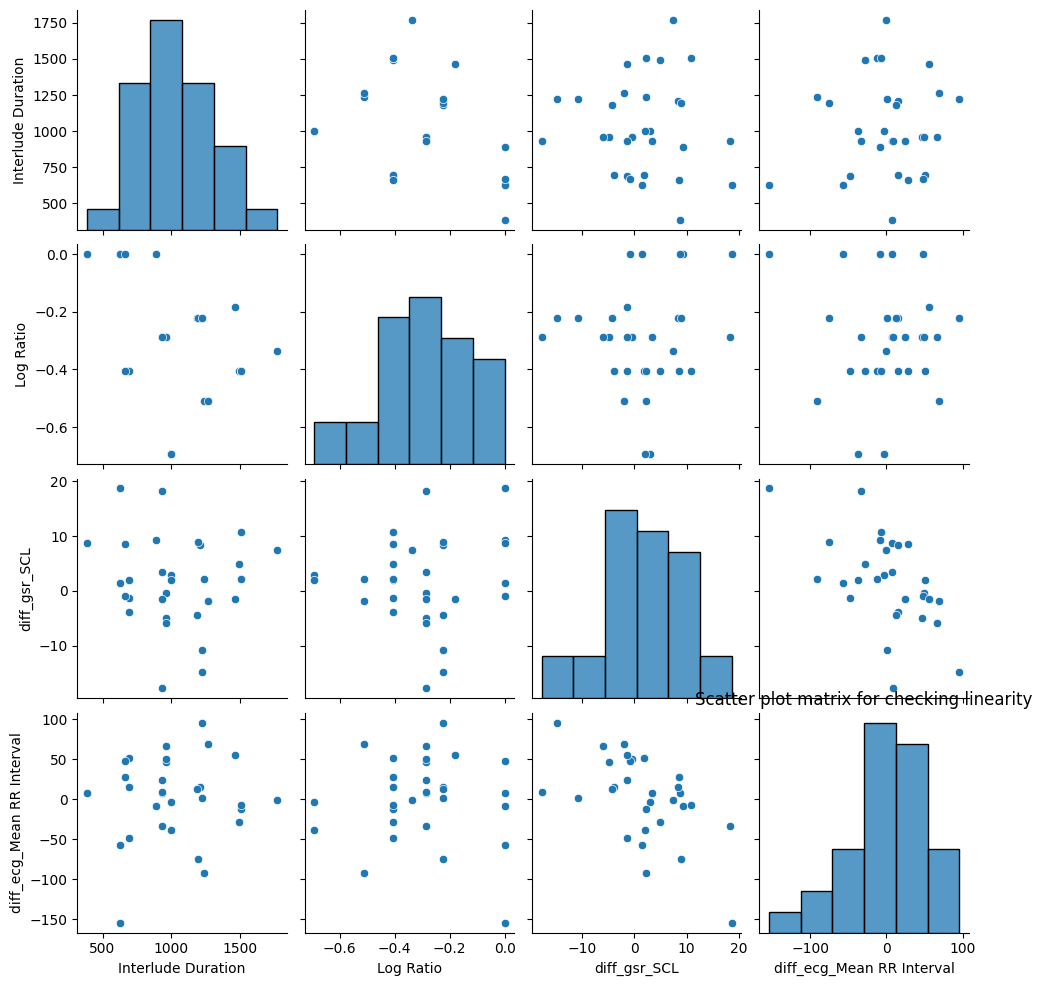

Variance Inflation Factor (without interaction):
             Variable       VIF
0  Interlude Duration  4.036633
1           Log Ratio  4.036633
Shapiro-Wilk test for diff_gsr_SCL: ShapiroResult(statistic=0.9699684977531433, pvalue=0.538313627243042)
Shapiro-Wilk test for diff_ecg_Mean RR Interval: ShapiroResult(statistic=0.9539547562599182, pvalue=0.21549177169799805)
Shapiro-Wilk test for Mahalanobis distances: ShapiroResult(statistic=1.0, pvalue=1.0)


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.9/site-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


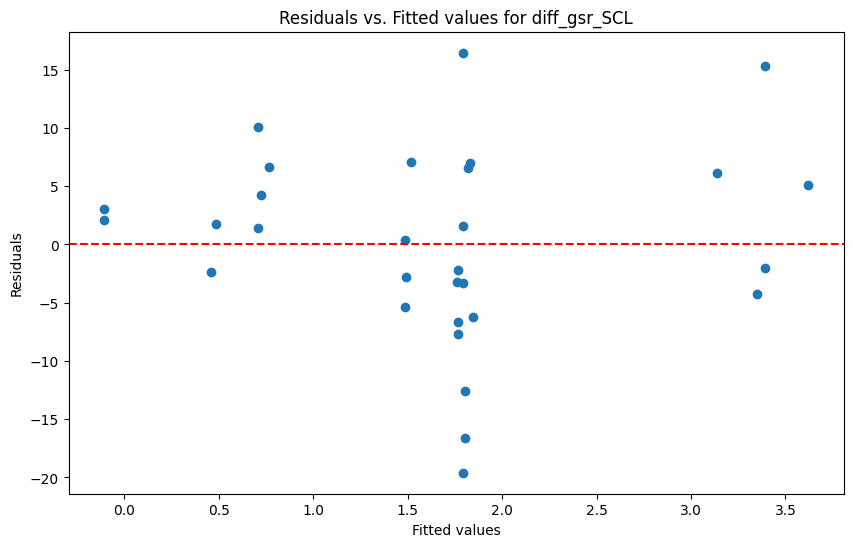

Breusch-Pagan test for diff_gsr_SCL: {'LM Statistic': 1.4709094675728396, 'LM-Test p-value': 0.4792874612111564, 'F-Statistic': 0.6960361315991773, 'F-Test p-value': 0.5072827309000104}


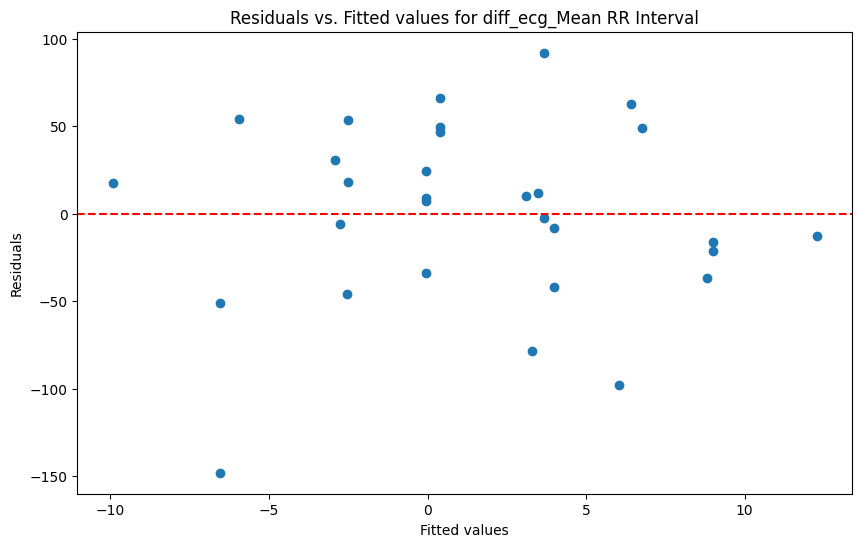

Breusch-Pagan test for diff_ecg_Mean RR Interval: {'LM Statistic': 1.6707995987553037, 'LM-Test p-value': 0.4337010533558636, 'F-Statistic': 0.796203008335017, 'F-Test p-value': 0.4613455497921055}


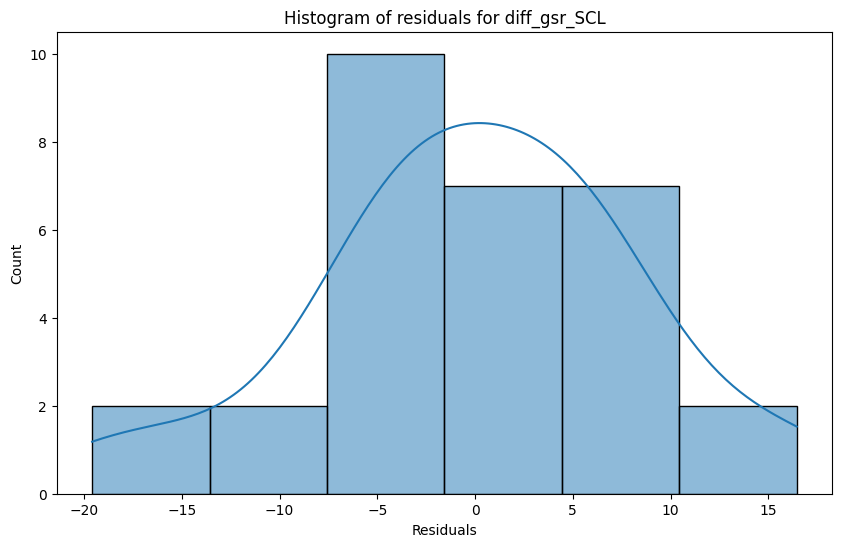

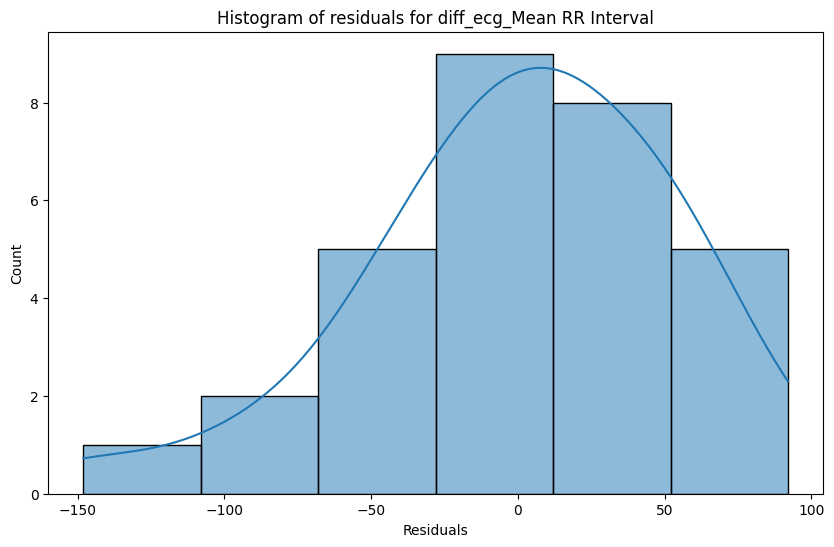

In [224]:
# Filter the relevant columns
relevant_columns = ['Interlude Duration', 'Log Ratio', 'diff_gsr_SCL', 'diff_ecg_Mean RR Interval']
mvar_data = data[relevant_columns]

# Define the formula correctly without the interaction term
formula = 'Q("diff_gsr_SCL") + Q("diff_ecg_Mean RR Interval") ~ Q("Interlude Duration") + Q("Log Ratio")'

# Fit the MANOVA model
mvar_model = MANOVA.from_formula(formula, data=mvar_data)
mvar_model_results = mvar_model.mv_test()


# Check assumptions

# 1. Linearity: Scatter plot matrix
sns.pairplot(mvar_data)
plt.title('Scatter plot matrix for checking linearity')
plt.show()

# 2. Multicollinearity: Variance Inflation Factor (VIF) without interaction term
X_no_interaction = mvar_data[['Interlude Duration', 'Log Ratio']]
vif_no_interaction = pd.DataFrame()
vif_no_interaction['Variable'] = X_no_interaction.columns
vif_no_interaction['VIF'] = [variance_inflation_factor(X_no_interaction.values, i) for i in range(X_no_interaction.shape[1])]
print(f'Variance Inflation Factor (without interaction):\n{vif_no_interaction}')

# 3. Multivariate Normality: Shapiro-Wilk test for each dependent variable
dependent_vars = ['diff_gsr_SCL', 'diff_ecg_Mean RR Interval']
for var in dependent_vars:
    shapiro_test = shapiro(mvar_data[var])
    print(f'Shapiro-Wilk test for {var}: {shapiro_test}')

# Multivariate Normality: Calculate Mahalanobis distances and test for normality
md = mahalanobis_distance(mvar_data[dependent_vars])
shapiro_test_md = shapiro(md)
print(f'Shapiro-Wilk test for Mahalanobis distances: {shapiro_test_md}')

# 4. Homoscedasticity: Plot residuals vs. fitted values and Breusch-Pagan test

# Fit OLS models for each dependent variable to get residuals
X = mvar_data[['Interlude Duration', 'Log Ratio']]
X = sm.add_constant(X)  # Add a constant term to the predictors

residuals = {}
for var in dependent_vars:
    model = sm.OLS(mvar_data[var], X).fit()
    residuals[var] = model.resid

    # Plot residuals vs. fitted values
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, model.resid)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs. Fitted values for {var}')
    plt.show()

    # Breusch-Pagan test for homoscedasticity
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print(f'Breusch-Pagan test for {var}: {dict(zip(labels, bp_test))}')

# Additional check: Plot residuals for normality
for var, resid in residuals.items():
    plt.figure(figsize=(10, 6))
    sns.histplot(resid, kde=True)
    plt.xlabel('Residuals')
    plt.title(f'Histogram of residuals for {var}')
    plt.show()


#### Fit Model 

In [225]:

# Filter the relevant columns
relevant_columns = ['Interlude Duration', 'Log Ratio', 'diff_gsr_SCL', 'diff_ecg_Mean RR Interval']
mvar_data = data[relevant_columns]

mvar_data_w_interaction = mvar_data.copy()

# Add the interaction term to the data
mvar_data_w_interaction['Interaction'] = mvar_data['Interlude Duration'] * mvar_data['Log Ratio']






###### With interaction term

In [226]:
# Define the formula with interaction
formula_w_interaction = 'Q("diff_gsr_SCL") + Q("diff_ecg_Mean RR Interval") ~ Q("Interlude Duration") + Q("Log Ratio") + Interaction'

# Fit the Mutlivariate Multiple Regression (MMR) model
mvar_model_w_interaction = MANOVA.from_formula(formula_w_interaction, data=mvar_data_w_interaction)
mvar_results_w_interaction = mvar_model_w_interaction.mv_test()

# Display the results
print(mvar_results_w_interaction)

                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.8510 2.0000 25.0000  2.1885 0.1331
          Pillai's trace 0.1490 2.0000 25.0000  2.1885 0.1331
  Hotelling-Lawley trace 0.1751 2.0000 25.0000  2.1885 0.1331
     Roy's greatest root 0.1751 2.0000 25.0000  2.1885 0.1331
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
 Q("Interlude Duration") Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.8640 2.0000 25.0000  1.9674 0.1609
          Pillai's trace 0.1360 2.0000 25.0000  1.9674 0.1609
  Hotelling-Lawley trace 0

###### Without interaction term

In [162]:
# Define the formula without the interaction term
formula_no_interaction = 'Q("diff_gsr_SCL") + Q("diff_ecg_Mean RR Interval") ~ Q("Interlude Duration") + Q("Log Ratio")'

# Fit the Multivariate Multiple Regression (MMR) model without the interaction term
mvar_model_no_interaction = MANOVA.from_formula(formula_no_interaction, data=mvar_data)
mvar_results_no_interaction = mvar_model_no_interaction.mv_test()

# Display the results
print(mvar_results_no_interaction)

                  Multivariate linear model
                                                             
-------------------------------------------------------------
        Intercept        Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.9793 2.0000 26.0000  0.2749 0.7618
          Pillai's trace 0.0207 2.0000 26.0000  0.2749 0.7618
  Hotelling-Lawley trace 0.0211 2.0000 26.0000  0.2749 0.7618
     Roy's greatest root 0.0211 2.0000 26.0000  0.2749 0.7618
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
 Q("Interlude Duration") Value  Num DF  Den DF F Value Pr > F
-------------------------------------------------------------
           Wilks' lambda 0.9929 2.0000 26.0000  0.0924 0.9120
          Pillai's trace 0.0071 2.0000 26.0000  0.0924 0.9120
  Hotelling-Lawley trace 0

## G*Power 